# АиФ "Доброе сердце"
Часть 2

Сегментирование пользователей: RFM-анализ, описание сегментов;

## Загрузка данных

### Импорт библиотек

In [1]:
import pandas as pd
pd.set_option('display.max_columns', None)

import plotly.express as px
import seaborn as sns
from datetime import datetime, timedelta

import numpy as np
import math as mth
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime, timedelta
import scipy.stats as st
from plotly import graph_objects as go
import plotly.express as px
import warnings
warnings.filterwarnings('ignore')



### order

In [2]:
order = pd.read_csv('order_step1.csv')
order = order[order['status'] == 'Paid']
order.head()

,Unnamed: 0,action_id,ordering_datetime,in_touch_point_id,ext_touch_point_id,new_year_promotion,next_pay_date,recurrent,repayment,product_id,product_name,price,status,mindbox_id,time,year,month,day,hour
0,0,57400,2022-01-27 03:00:00,1,Administrator,False,NaN,NaN,NaN,9847,Никита Суриков,500,Paid,6959,3,2022,1,27,3
1,1,57577,2022-01-29 03:00:00,1,Administrator,False,NaN,NaN,NaN,9847,Никита Суриков,200,Paid,7103,3,2022,1,29,3
2,2,57807,2022-01-31 03:00:00,1,Administrator,False,NaN,NaN,NaN,9847,Никита Суриков,300,Paid,7321,3,2022,1,31,3
3,3,57933,2022-02-06 03:00:00,1,Administrator,False,NaN,NaN,NaN,9847,Никита Суриков,300,Paid,7143,3,2022,2,6,3
4,4,59062,2022-02-28 03:00:00,1,Administrator,False,NaN,NaN,NaN,1,На уставную деятельность,50,Paid,7079,3,2022,2,28,3


In [3]:
order['ordering_datetime'] = pd.to_datetime(
    order['ordering_datetime'], format='%Y-%m-%d')

In [4]:
users = len(order['mindbox_id'].unique())
users

18721

In [5]:
prices = order['price'].sum()
prices

39014804

## RFM

По каждому покупателю выделяем информацию для анализа:

— как давно была последняя покупка (Recency);

— сколько всего было покупок всего (Frequency);

— сумма всех покупок (Monetary).

In [6]:
# Устанавливаем отчетную дату на +1 день к финальной дате датасета
now = order.ordering_datetime.dt.date.max() + pd.Timedelta('1d')
now

datetime.date(2024, 3, 19)

In [7]:
order['ordering_date'] = order['ordering_datetime'].dt.date

In [8]:
rfm = order.groupby('mindbox_id').agg({'ordering_date': ['max', 'count'], 'price': 'sum'})
rfm.columns = ['last_date', 'total_orders', 'total_sum']
rfm.head()

,last_date,total_orders,total_sum
mindbox_id,,,
2734,2021-10-14,2,51
2847,2023-12-15,3,1000
2861,2022-12-07,7,120
3361,2022-12-20,1,3000
4982,2024-02-13,11,840


### Recency
- как давно была последняя покупка
- Давность заказа: 1 — давние, 2 — «спящие», 3 — недавние;

In [9]:
# рассчет по тому как давно заходили последний раз в днях
rfm['days_inactive'] = (now - rfm['last_date'])

In [10]:
rfm['R'] = pd.qcut(rfm['days_inactive'], 3, labels=[3, 2, 1])

In [11]:
print(f'1:{rfm[rfm["R"] == 1]["days_inactive"].min()} - {rfm[rfm["R"] == 1]["days_inactive"].max()}')
print(f'2:{rfm[rfm["R"] == 2]["days_inactive"].min()} - {rfm[rfm["R"] == 2]["days_inactive"].max()}')
print(f'3:{rfm[rfm["R"] == 3]["days_inactive"].min()} - {rfm[rfm["R"] == 3]["days_inactive"].max()}')

1:572 days 00:00:00 - 1173 days 00:00:00
2:170 days 00:00:00 - 571 days 00:00:00
3:1 days 00:00:00 - 169 days 00:00:00


### Frequency
- сколько всего было покупок всего
- Частота покупок: 1 — разовые, 2 — редкие, 3 — частые;

In [12]:
pd.qcut(rfm['total_orders'].value_counts(), 3).unique()

[(16.333, 12916.0], (2.0, 16.333], (0.999, 2.0]]
Categories (3, interval[float64, right]): [(0.999, 2.0] < (2.0, 16.333] < (16.333, 12916.0]]

In [13]:
bins = [0.999, 2.0, 16.0, 12745.0]
labels=[1, 2, 3]

In [14]:
rfm['F'] = pd.cut(rfm['total_orders'], bins=bins, labels=labels)
print(f'1:{rfm[rfm["F"] == 1]["total_orders"].min()} - {rfm[rfm["F"] == 1]["total_orders"].max()}')
print(f'2:{rfm[rfm["F"] == 2]["total_orders"].min()} - {rfm[rfm["F"] == 2]["total_orders"].max()}')
print(f'3:{rfm[rfm["F"] == 3]["total_orders"].min()} - {rfm[rfm["F"] == 3]["total_orders"].max()}')

1:1 - 2
2:3 - 16
3:17 - 157


### Monetary
- сумма всех покупок
- 1 — низкий чек, 2 — средний чек, 3 — высокий чек

In [15]:
rfm['M'] = pd.qcut(rfm['total_sum'], 3, labels=[1, 2, 3])
print(f'1:{rfm[rfm["M"] == 1]["total_sum"].min()} - {rfm[rfm["M"] == 1]["total_sum"].max()}')
print(f'2:{rfm[rfm["M"] == 2]["total_sum"].min()} - {rfm[rfm["M"] == 2]["total_sum"].max()}')
print(f'3:{rfm[rfm["M"] == 3]["total_sum"].min()} - {rfm[rfm["M"] == 3]["total_sum"].max()}')

1:0 - 300
2:301 - 1000
3:1003 - 1072500


### Итог

In [16]:
rfm['RFM'] = rfm['R'].astype('string') + rfm['F'].astype('string') + rfm['M'].astype('string')

In [17]:
rfm = rfm.reset_index()
rfm

,mindbox_id,last_date,total_orders,total_sum,days_inactive,R,F,M,RFM
0,2734,2021-10-14,2,51,887 days,1,1,1,111
1,2847,2023-12-15,3,1000,95 days,3,2,2,322
2,2861,2022-12-07,7,120,468 days,2,2,1,221
3,3361,2022-12-20,1,3000,455 days,2,1,3,213
4,4982,2024-02-13,11,840,35 days,3,2,2,322
...,...,...,...,...,...,...,...,...,...
18716,46782,2024-03-18,1,500,1 days,3,1,2,312
18717,46783,2024-03-18,1,120,1 days,3,1,1,311
18718,46784,2024-03-18,1,300,1 days,3,1,1,311
18719,46787,2024-03-18,1,300,1 days,3,1,1,311


Как читать:

|R - recency|F - frequency|M - monetary|
|:--|:--|:--|
|**1** - был более 572 дней назад|**1** - сделал более 16 покупок |**1** - заплатил менее 300 рублей за все время|
|**2** - был от 170 до 571 дней назад|**2** - сделал от 3 до 16 покупок |**2** - заплатил от 301 до 1000 рублей за все время|
|**3** - был менее 169 дней назад|**3** - делал менее 2 покупок |**3** - заплатил более 1001 рублей за все время|

Например, 122 - это пользователь, который был более 572 дней назад, сделал от 3 до 16 покупок, заплатил от 301 до 1000руб за все время. Лучшие пользователи - которые были недавное, сделали много покупок и на большую сумму - это 313

In [18]:
rfm_info = rfm.groupby('RFM').agg({'total_orders': 'mean',
                        'days_inactive': 'mean',
                        'total_sum': ['mean', 'sum'],
                        'mindbox_id': 'nunique'})

In [19]:
rfm_info.columns = [#'RFM',
                    'mean_visits', 'mean_days_inactive', 'mean_order', 'total_sum', 'total_users']

In [20]:
rfm_info.style.format(thousands='.', decimal=',', precision=2).highlight_max(color='forestgreen')

,mean_visits,mean_days_inactive,mean_order,total_sum,total_users
RFM,,,,,
111,"1,05",776 days 07:54:45.523071504,"187,66",532.774,2.839
112,"1,11",785 days 18:25:21.878862792,"677,15",1.643.440,2.427
113,"1,24",834 days 15:01:30.150250416,"6.019,20",3.605.499,599
121,"4,26",812 days 04:14:07.058823528,"193,50",6.579,34
122,"4,62",801 days 14:00:00,"667,80",72.122,108
123,"5,82",773 days 12:48:52.126696832,"8.121,92",1.794.945,221
131,"26,00",650 days 00:00:00,"90,00",90,1
133,"36,50",730 days 15:00:00,"42.050,00",336.400,8
211,"1,07",332 days 06:57:49.806560136,"212,39",505.067,2.378


Много пользователей, которые были давно, сделали много покупок на разные суммы. В целом, по части 1 уже знаем, что делать разовые пожертвования весьма популярно, поэтому тут так много пользователей. Также выбиваются 233 - те, кто сделал до 2 транзакций, но на крупные суммы.
Немного беспокоят пользователи 113, которые давно были, часто и много платили. Они отсутствуют уже более 2 лет.
Больше всего денег принесла 323 - недавно были, сделали от2 до 16 транзакций на сумму более 1тыс.
И последнее 133 - были давно, заплатили не более пары раз но уже более 1001руб, у таких и среднее визитов весьма велика, и среднее 42тыс. 


## Проверка

In [21]:
print(f'Количество пользователей во всех сегментах: {rfm_info.total_users.sum()} человек')
rfm_info.total_users.sum() == users

Количество пользователей во всех сегментах: 18721 человек


True

In [22]:
print(f'Общая сумма пожертвований по всем сегментам: {rfm_info.total_sum.sum():,.0f} рублей')
rfm_info.total_sum.sum() == prices

Общая сумма пожертвований по всем сегментам: 39,014,804 рублей


True

## Аналитика

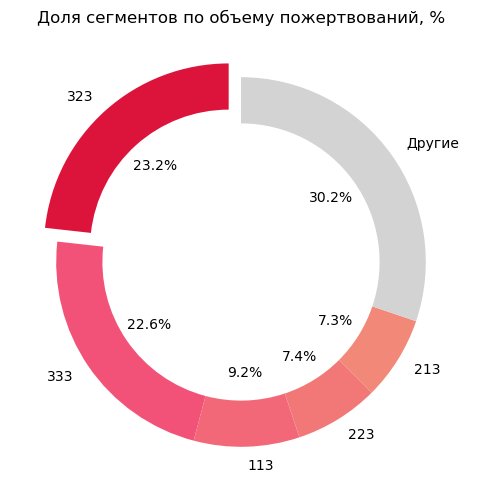

In [31]:
top = 5
areas_df = rfm_info.sort_values(by='total_sum',ascending=False)['total_sum']
other = areas_df[areas_df.values <= areas_df[top]].sum()
areas_df = pd.concat([areas_df.head(top), pd.Series({'Другие': other})])

explode = (0.1,) + (0,)*top #* (top - 1)
# red color
colors = ['crimson'] + ['#F25278','#F26878','#F27878','#F28878'] + ['lightgrey']

plt.figure(figsize=(6, 6))
areas_df.plot(kind='pie', autopct='%1.1f%%', startangle=90, colors = colors,
            wedgeprops=dict(width=0.25), explode= explode)
plt.title('Доля сегментов по объему пожертвований, %');

In [33]:
rfm_graph = rfm_info.sort_values(by='total_sum',ascending=False).reset_index()

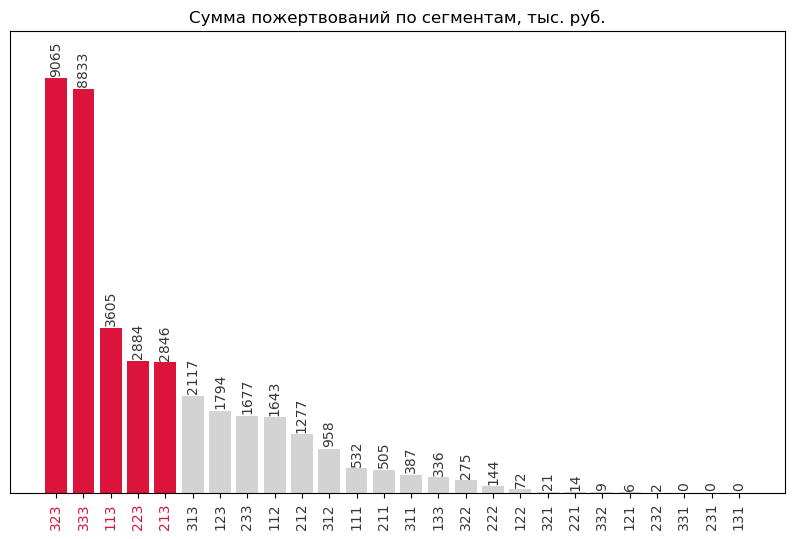

In [34]:
plt.figure(figsize=(10, 6))

bar_colors = ['lightgrey']  *  len(rfm_graph.RFM)
for num in range(5):
    bar_colors[num] = 'crimson'

plt.title('Сумма пожертвований по сегментам, тыс. руб.')
plt.bar(x=rfm_graph.RFM, height=rfm_graph.total_sum / 1000, color=bar_colors)

for x, y, tex in zip(rfm_graph.RFM, rfm_graph.total_sum/1000, rfm_graph.total_sum/1000):
    t = plt.text(x, y+50, int(tex),
                 horizontalalignment='center',
                 rotation='vertical',
                 verticalalignment='bottom',
                 fontdict={'color':'#373737', 'size': 10})

ax = plt.gca()
ax.get_yaxis().set_visible(False)

tick_colors = ['#373737'] * len(rfm_graph.RFM)
for num in range(5):
    tick_colors[num] = 'crimson'
for ticklabel, tickcolor in zip(plt.gca().get_xticklabels(), tick_colors):
    ticklabel.set_color(tickcolor)

plt.xticks(rotation=90)
plt.ylim(0, 10100)
plt.show();

Больше всего приносят доход 323 и 333, суммарно занимая почти половину доходов. 3 основных сегмента уже составляют больше 50% всего дохода фонда.